# Assingment 2 - Tumor segmentation
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

Previously you have looked at the different available contrasts of the same anatomy, but the dataset also contains a manually segmented binary map of a tumor, if visible on the slice. For the second assignment your task is to create a tumor segmentation model that takes any number of image contrasts as an input, and outputs the tumor segmentations. For this task, you will implement and use the [DICE](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) score to evaluate (aim for a DICE score higher than $0.8$ on the validation set).

Your task is to look through the highly customizable code below, which contains all the main steps for image segmentation from using only one contrast as an input. By changing the arrays of the DataGenerator, multiple contrasts can be added as input, similar as in Assignment 1. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the Jupyter notebook you hand in, are:
- How you reached the required performances (DICE score above 0.8)
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Once you have reached the required loss on the validation data, and you have selected your final model, only then evaluate your model on the testing data as well.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the provided network and training, and how you solved them.

Upload the updated notebook to Canvas by March $31^{th}$, 15:00.

Good luck and have fun!

In [169]:
import os

import numpy as np
np.random.seed(2022)  # Set seed for reproducibility

import tensorflow as tf
tf.random.set_seed(2022)

import random
random.seed(2022)

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# release gpu mem
keras.backend.clear_session()
    
# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [170]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!

## Input
I chose to only use the FLAIR type as input to my model, as defined below. I did this because by first visualizing all the different labels (T1, T1CE, FLAIR) and comparing them with the corresponding masks I found that it was, on average, easiest to detect the tumor in the FLAIR images. After reaching the desired DICE score with only FLAIR I tried to expand my model to incorporate the T2 images as well, as they were the next best in my opinion. I only managed to reach a DICE score of ~0.75 though so I decided to stick with FLAIR only.

A batch size of 16 was used as it seemed to yield a good balance between training speed, memory requirements and training accurracy.

In [171]:
gen_dir = "data/" #"/import/software/3ra023/vt22/brats/data/"  # Change if you have copied the data locally on your machine 
input_labels = ["flair"]
gt_label = "mask"
array_labels = input_labels + [gt_label]  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
batch_size = 16

gen_train = DataGenerator(data_path=gen_dir + "training",
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + "validating",
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + "testing",
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? You can use multiple contrasts as inputs, if you'd like.
# NOTE: Which contrasts do you think are the best to use for tumor segmentation? Try plotting them all.
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

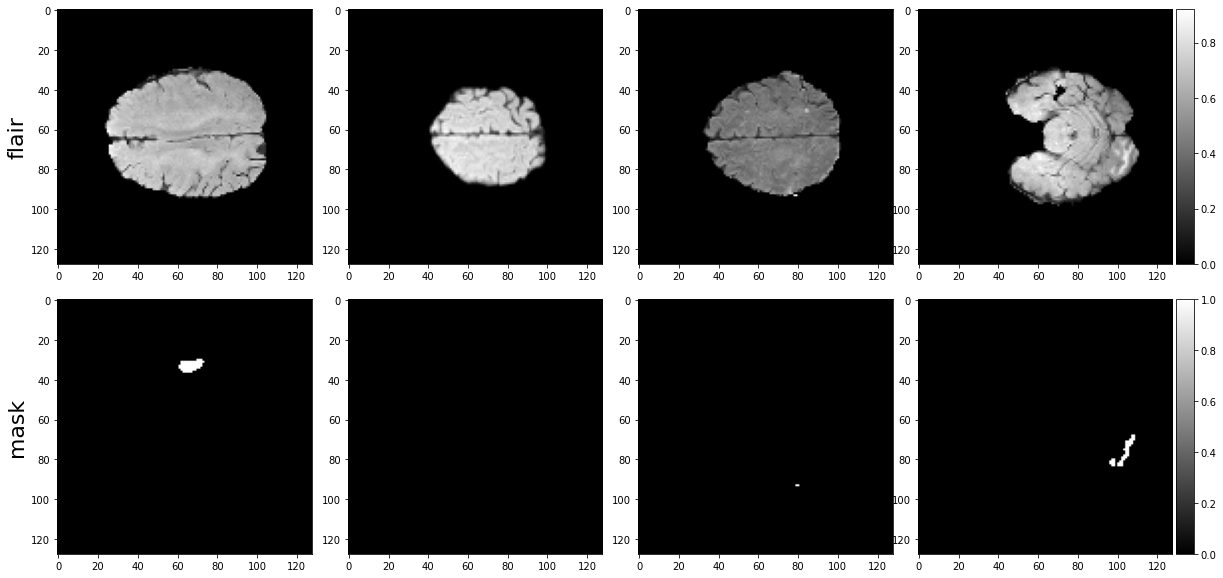

In [172]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16.0, 8.0))
fig.subplots_adjust(left=0.001,
                    right=0.9975,
                    top=0.95,
                    bottom=0.005,
                    wspace=0.05,
                    hspace=0.14)

M, N = len(array_labels), 4
ax = []
for i in range(M):
    ax.append([None] * N)
    for j in range(N):
        ax[i][j] = plt.subplot2grid((M, N), (i, j), rowspan=1, colspan=1)

batch_idx = np.random.randint(0, len(gen_train))
imgs = gen_train[batch_idx]
idx = [0,1,2,3]  # Plot images in mini-batch with these indices
ii = 0

for j in range(N):
    for i in range(M):
        im = ax[i][j].imshow(imgs[i][idx[ii], :, :, 0], cmap='gray')
       #im = ax[i][j].imshow(input_imgs[idx[ii], :, :, 0], cmap='gray')

        if j == 0:  # Label only on the left
            ax[i][j].set_ylabel(gen_train.arrays[i], fontsize=22)
        if j == N - 1:  # Colorbar only on the right
            divider = make_axes_locatable(ax[i][j])
            cax1 = divider.append_axes("right", size="7%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax1)
    ii += 1    

A quick summary of the data sizes:

In [173]:
# A quick summary of the data:
print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")

Number of training images : 8000
Training batch size       : [(16, 128, 128, 1), (16, 128, 128, 1)]


### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

In [174]:
# Import packages important for building and training your model.

import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, concatenate, add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

## A note on augmentation
My initial tests performed data augmentations similar to Lab 1, where input images were rotated, translated and scaled. However, this only seemed to make the model perform worse, so I decided to not use augmentation in this lab. It is possible
that the augmentations performed were too harsh, but I could not properly test this due to insufficient time.


# Discussion and thoughts around my model design

## Describe the thought process behind building your model and choosing the model hyper-parameters.
I started this task by researching the U-Net model which was hinted at in the comments of this lab. From my understanding it is a very common model to use when performing image segmentation, so that was the first and final model that I implemented. The model consists of an encoder part and a decoder part. The encoder part continually downsamples the input while applying convolutional layers to learn different key features of the image. The decoder part performed transpose convolutions to upsample the data back to the original input size (see plot of model below). Filter maps learned at the different stages in the encoder part was also concatenated into the corresponding layers in the decoder part. This was done to try and bring lower level features learned in those earlier layers along to the output. The final layer is a convolutional layer with 1 filter and a 1x1 kernel that perform the sigmoid activation function to be able to interpret the output as a probability of belonging to the mask (tumor).

I experimented with mainly 4 different types of hyper parameters: An initial filter size (all others were always 2x the size of the previous one if downsampling, or 1/2x if upsizing), batch normalization, kernel regularization and dropout. I did some informed guesses here and there, taking in a lot of learnings from the first assignment. I found that it was best to use an initial batch normalization on the first two convolutional layers, and a dropout of 0.2 on the last two layers. I also experimented with kernel regularizers but found that they greatly decreased the model's performance so I decided to not use them for this lab.

## Describe what you think are the biggest issues with the provided network and training, and how you solved them.
The provided model consisted of the following: Conv2D(2 filters, 3x3 kernel, RELU activation)->Pool(2x2 size)->Conv2D(4 filters, 3x3 kernel, RELU activation)->UpPool(2x2 size)->Conv2D(1 filter, 3x3 kernel, TanH activation). We can directly realize that this is a far too simple model that simply do not have sufficient capacity to learn enough important features. The output activation function, *tanh* is not a suitable activation function either, or at least not directly when using DICE as a loss function as defined below, as it expects an input between 0 and 1 (interpreted as a probability), while tanh maps $\mathbb{R}$ -> (-1, 1). I solved these problems by constructing a more complex model with much higher capacity, and using the sigmoid activation function as output.

In [175]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model

def double_conv_block(x, filters, batch_norm = False, kernel_regularizer = None):
    x = Conv2D(filters, 3, padding='same', kernel_regularizer=kernel_regularizer, kernel_initializer='he_normal')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same', kernel_regularizer=kernel_regularizer, kernel_initializer='he_normal')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def downsample_block(x, filters, dropout = 0.0, batch_norm = False, kernel_regularizer = None):
    f = double_conv_block(x, filters, batch_norm, kernel_regularizer)
    p = MaxPooling2D(2)(f)

    if dropout > 0.0:
        p = Dropout(dropout)(p)

    return f,p

def upsample_block(x, residual, filters, dropout = 0.0, batch_norm = False, kernel_regularizer = None):
    x = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=kernel_regularizer, kernel_initializer='he_normal')(x)
    x = concatenate([x, residual])

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = double_conv_block(x, filters, batch_norm, kernel_regularizer)
    
    return x

def build_model():
    start_filters = 64;

    inputs = Input(shape=(128, 128, 1))

    # encoder part 
    f1,p1 = downsample_block(inputs, start_filters, batch_norm=True)
    f2,p2 = downsample_block(p1, start_filters * 2)
    f3,p3 = downsample_block(p2, start_filters * 4)
    f4,p4 = downsample_block(p3, start_filters * 8)

    bottleneck = double_conv_block(p4, start_filters * 16)
    
    # decoder part
    u1 = upsample_block(bottleneck, f4, start_filters * 8)
    u2 = upsample_block(u1, f3, start_filters * 4)
    u3 = upsample_block(u2, f2, start_filters * 2, dropout=0.2)
    u4 = upsample_block(u3, f1, start_filters, dropout = 0.2)

    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(u4)
    
    return Model(inputs, outputs)

# NOTE: Be inspired by the imported layers.
# NOTE: Probably the most famous model architecture for segmentation is the U-Net.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

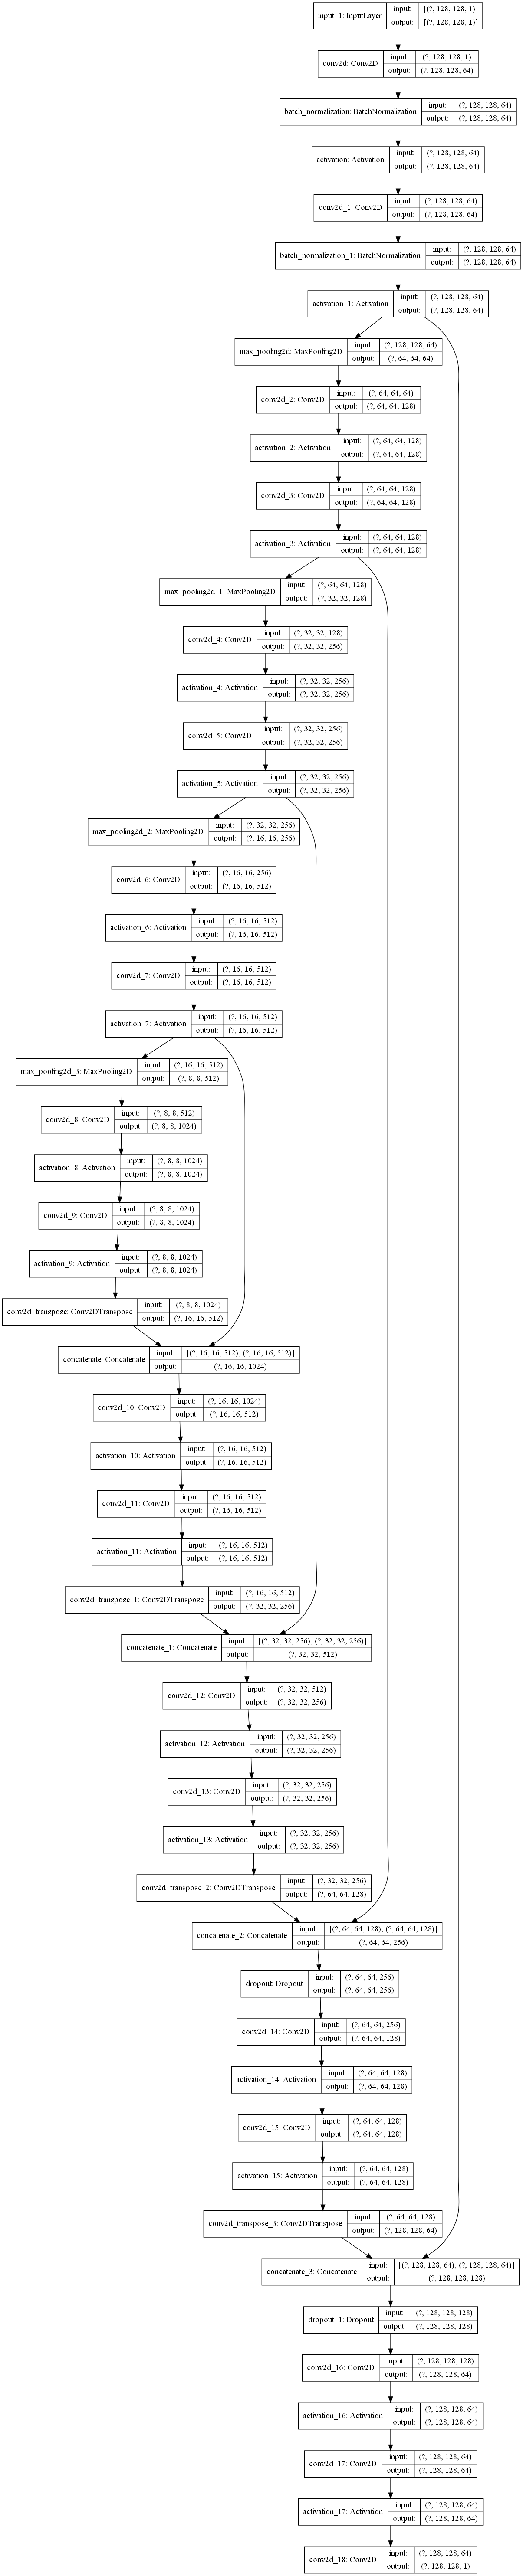

In [176]:

# Build your model.
model = build_model()

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


# NOTE: Are the input sizes correct?
# NOTE: Do you have the correct number of input images?
# NOTE: Are the output sizes correct?
# NOTE: Do you have the correct number of output images?
# NOTE: What's the range of the output? Can you use an activation as a regularizer?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are your parameters split evenly inside the model? Try making "too large" layers smaller
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

## Small discussion on the loss function
Initially I used the binary crossentropy loss function, however I quickly saw that it did not perform well. It resulted in a top validation DICE score of ~0.6, and with an always *increasing* validation loss, which to me was really weird. Im still not entierly sure what it means when the loss and DICE metric was increasing, as the model was clearly learning. I did try to research this and it seems like the cross entropy function can heavily penalize miss-predictions (due to the logarihm of something close to zero), and, since it is not a relative measure, it can also weigh large masks/tumors as more important than smaller ones, which could throw of the learning. The DICE metric on the other hand, is a relative measure. This means that it considers it equally important to correctly segment very small masks as very large masks, the actual pixel area of the tumor is of no importance, only the relative proportion of correctly classified pixels to total pixels of predicted and ground truth. So after realizing this I switched to using the DICE metric as a loss as well, using 1 - DICE_SCORE as loss function.

In [177]:
def dice_coef(y_true, y_pred, smooth=0.001):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2.0 * intersection + smooth) / (union + smooth), axis = 0)

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth)
    return dice

def dice_metric(smooth):
    def dice(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth)
    return dice

learning_rate = 0.000005
dice_smooth = 0.001
optim = optimizers.Adam(learning_rate=learning_rate)
custom_metric = dice_metric(dice_smooth)#'accuracy'

#loss_func = keras.losses.BinaryCrossentropy(from_logits=False)
loss_func = dice_loss(dice_smooth)
model.compile(
    loss=loss_func,
    optimizer=optim,
    metrics = [custom_metric]
 )

# NOTE: Are you satisfied with the optimizer and its parameters?
# NOTE: Try incorporating the DICE score into the model. Is it a loss function? Or a metric?

## When to stop training
I stopped training when the validation DICE score was above 0.8, as that was the requirement for this lab. It would however be interesting to keep going and see how good it could be. I did not have time for this however.

In [ ]:
n_epochs = 50

# Although lists here are lampeled as x_acc, they represent the DICE score.

training_loss = []
training_acc = []

validation_loss = []
validation_acc = []

for epoch in range(n_epochs):
    batches_training_loss = []
    batches_training_acc = []
    
    batches_validation_loss = []
    batches_validation_acc = []
    
    for batch in gen_train:
        X = batch[:-1]
        y = batch[-1]
        X_concat = np.concatenate(X, axis=0)
        y = [y for i in range(len(X))]
        y_concat = np.concatenate(y, axis=0)

        (batch_train_loss, batch_train_acc) = model.train_on_batch(X_concat, y_concat)
        batches_training_loss.append(batch_train_loss)
        batches_training_acc.append(batch_train_acc)
    
    for batch in gen_val:
        X = batch[:-1]
        y = batch[-1]
        X_concat = np.concatenate(X, axis=0)
        y = [y for i in range(len(X))]
        y_concat = np.concatenate(y, axis=0)

        (batch_validation_loss, batch_validation_acc) = model.test_on_batch(X_concat,y_concat)
        batches_validation_loss.append(batch_validation_loss)
        batches_validation_acc.append(batch_validation_acc)
        
    epoch_train_loss = np.mean(batches_training_loss)
    epoch_train_acc = np.mean(batches_training_acc)
    
    epoch_val_loss = np.mean(batches_validation_loss)
    epoch_val_acc = np.mean(batches_validation_acc)
    
    print(f"Epoch {epoch}, traininig: loss {epoch_train_loss:.9f} DICE: {epoch_train_acc:.3f}, validation: loss {epoch_val_loss:.4f} DICE: {epoch_val_acc:.3f}")
    
    training_loss.append(epoch_train_loss)
    training_acc.append(epoch_train_acc)
    
    validation_loss.append(epoch_val_loss)
    validation_acc.append(epoch_val_acc)
    
    gen_train.on_epoch_end()

    if epoch_val_acc > 0.8:
        print(f"Got required validation DICE score of {epoch_val_acc}! Terminating training.")
        break

# NOTE: Plotting the losses helps a lot.
# NOTE: What does plotting the training data tell you? Should you plot something else?
# NOTE: What should one do with the validation data? The fit_generator has a 'validation_data' argument as well.
# NOTE: When should one stop? Did you overtrain? Did you train for long enough?
# NOTE: Think about implementing Early Stopping?

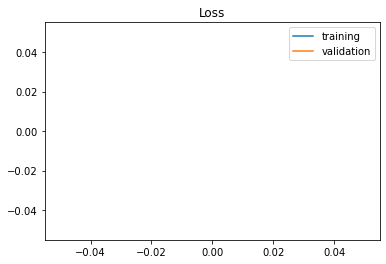

Text(0.5, 1.0, 'DICE score')

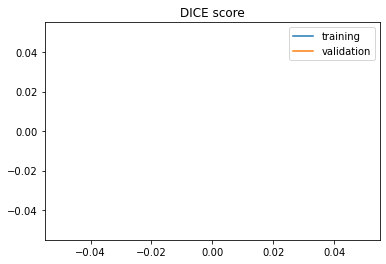

In [ ]:
n_epochs = len(training_loss)
epoch_arr = np.arange(0, n_epochs)

plt.plot(epoch_arr, training_loss, label='training')
plt.plot(epoch_arr, validation_loss, label='validation')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(epoch_arr, training_acc, label='training')
plt.plot(epoch_arr, validation_acc, label='validation')
plt.legend()
plt.title("DICE score")

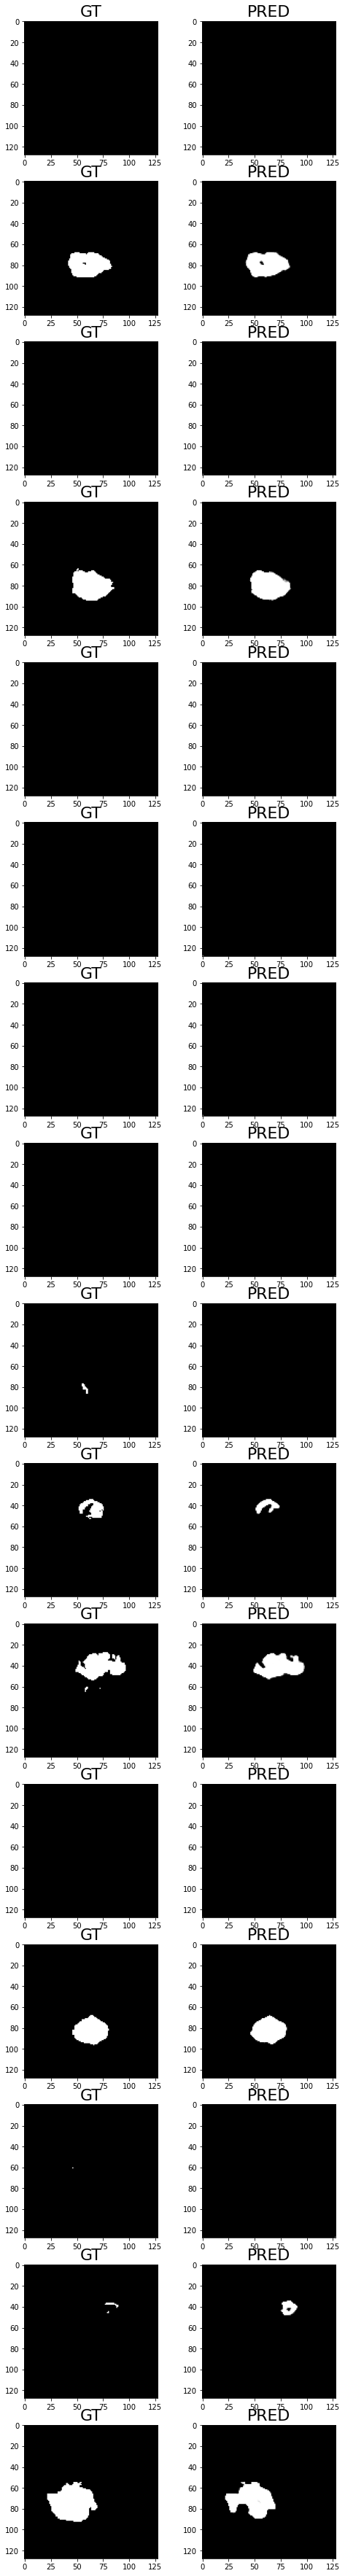

In [ ]:
batch = gen_val[np.random.randint(0, len(gen_val))]
X = batch[:-1]
y = batch[-1]
prediction = model.predict(X)

plt.figure(figsize=(8, 4*batch_size))
for idx in range(batch_size):
    plt.subplot(batch_size, 2, idx * 2 + 1)
    plt.imshow(y[idx, :, :], cmap='gray')
    plt.title('GT', fontsize=22)
    plt.subplot(batch_size, 2, idx * 2 + 2)
    plt.imshow(prediction[idx, :, :], cmap='gray')
    plt.title('PRED', fontsize=22)
    
# NOTE: What do the predictions mean? What values do they take?
# NOTE: How can your predictions be used as masks?

In [ ]:
def get_full_dataset(generator):
    batch = generator[0]
    X = batch[:-1]
    y = batch[-1]
    y = [y for i in range(len(X))]
    full_inputs = np.concatenate(X, axis=0)
    full_masks = np.concatenate(y, axis=0)
    for idx, batch in enumerate(generator):
        if idx == 0:
            continue
    
        X = batch[:-1]
        a = np.concatenate(X, axis=0)
        full_inputs = np.concatenate((full_inputs, a), axis=0)

        y = batch[-1]
        y = [y for i in range(len(X))]
        a = np.concatenate(y, axis=0)
        full_masks = np.concatenate((full_masks, a), axis=0)
    
    return (full_inputs, full_masks)

# Evaluate validation data
inputs, masks = get_full_dataset(gen_val)
final_results = model.evaluate(inputs, masks)
print(final_results)

(992, 128, 128, 1)
(992, 128, 128, 1)
31/31 [==============================] - 2s 77ms/step - loss: 0.1866 - dice: 0.8134
[0.18663547933101654, 0.8133646249771118]


In [ ]:
# And finally evaluate test data!
inputs, masks = get_full_dataset(gen_test)
test_results = model.evaluate(inputs, masks)

31/31 [==============================] - 2s 79ms/step - loss: 0.1590 - dice: 0.8410
